# **Enhancing Email Communication with AI: Mitigating Misinterpretation through Sentiment and Tone Analysis**

In [14]:
# Dependencies to be installed
!pip install language-tool-python matplotlib nltk seaborn spacy textblob textstat transformers

In [15]:
# Libraries to be imported
import language_tool_python
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import spacy
from textblob import TextBlob
import textstat
from transformers import pipeline

import re
import matplotlib.pyplot as plt
import seaborn as sns

### **Punkt**
Tokenizer models that split text into sentences or words.
- Key Features:
  - Language-agnostic
  - Includes pre-trained models for sentence segmentation in multiple languages

### **VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicon**
Pre-built collection of words with associated properties used for sentiment analysis. VADER is especially effective for social media text, casual text, or short-form text like tweets.
- Key Features:
  - Assigns sentiment scores (positive, negative, neutral, and compound) to text
  - Accounts for intensifiers, negations, and emoticons

In [16]:
# Ensure necessary NLTK data files are downloaded
nltk.download('punkt')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## **Approach 1 - Basic Email Analysis**

The first approach implements a simple email analysis pipeline using nltk for sentiment analysis, TextBlob for readability checks, and language_tool_python for grammar corrections.

- **Sentiment Analysis**: The sentiment of the email is assessed using the SentimentIntensityAnalyzer from nltk. This tool calculates the "compound" score, which ranges from -1 (negative sentiment) to +1 (positive sentiment). Based on the score, the email is classified into positive, neutral, or negative categories.

- **Clarity and Readability**: Using TextBlob, we assess the polarity of the email, which helps determine if the text is more positive or negative in terms of its sentiment. We also evaluate the overall readability score, which is a basic approximation of how easily the content can be understood by a reader.

- **Grammar and Spelling Correction**: The language_tool_python library identifies spelling and grammatical errors in the email and provides suggestions for improvements.

- **Emotion Detection**: The presence of emotional indicators like "happy", "sad", "angry", or "confused" is detected using a simple keyword-based approach.

In [17]:
def analyze_email(email_content):
    # Initialize sentiment analyzer
    sia = SentimentIntensityAnalyzer()
    # Sentiment Analysis
    sentiment_score = sia.polarity_scores(email_content)
    sentiment = "Neutral"
    if sentiment_score['compound'] >= 0.05:
        sentiment = "Positive"
    elif sentiment_score['compound'] <= -0.05:
        sentiment = "Negative"

    # Clarity and Readability Check
    blob = TextBlob(email_content)
    readability_score = blob.sentiment.polarity
    # Grammar and Spelling Correction
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(email_content)
    corrected_email = language_tool_python.utils.correct(email_content, matches)

    # Emotion Detection (using TextBlob for simplicity)
    emotion = {
        "happy": "😊" if "happy" in email_content else "",
        "sad": "😢" if "sad" in email_content else "",
        "angry": "😡" if "angry" in email_content else "",
        "confused": "😕" if "confused" in email_content else ""
    }

    return {
        "sentiment": sentiment,
        "readability_score": readability_score,
        "corrected_email": corrected_email,
        "detected_emotions": emotion
    }

# Example email input
email_content = """
Hi team,

I am really confused about the project delays. We should have done better.
Please let me know what is happening.

Thanks.
"""

# Analyze the email
analysis_result = analyze_email(email_content)

# Print the results
print("Sentiment:", analysis_result["sentiment"])
print("Readability Score:", analysis_result["readability_score"])
print("Corrected Email:\n", analysis_result["corrected_email"])
print("Detected Emotions:", analysis_result["detected_emotions"])


Sentiment: Positive
Readability Score: 0.09999999999999999
Corrected Email:
 
Hi team,

I am really confused about the project delays. We should have done better.
Please let me know what is happening.

Thanks.

Detected Emotions: {'happy': '', 'sad': '', 'angry': '', 'confused': '😕'}


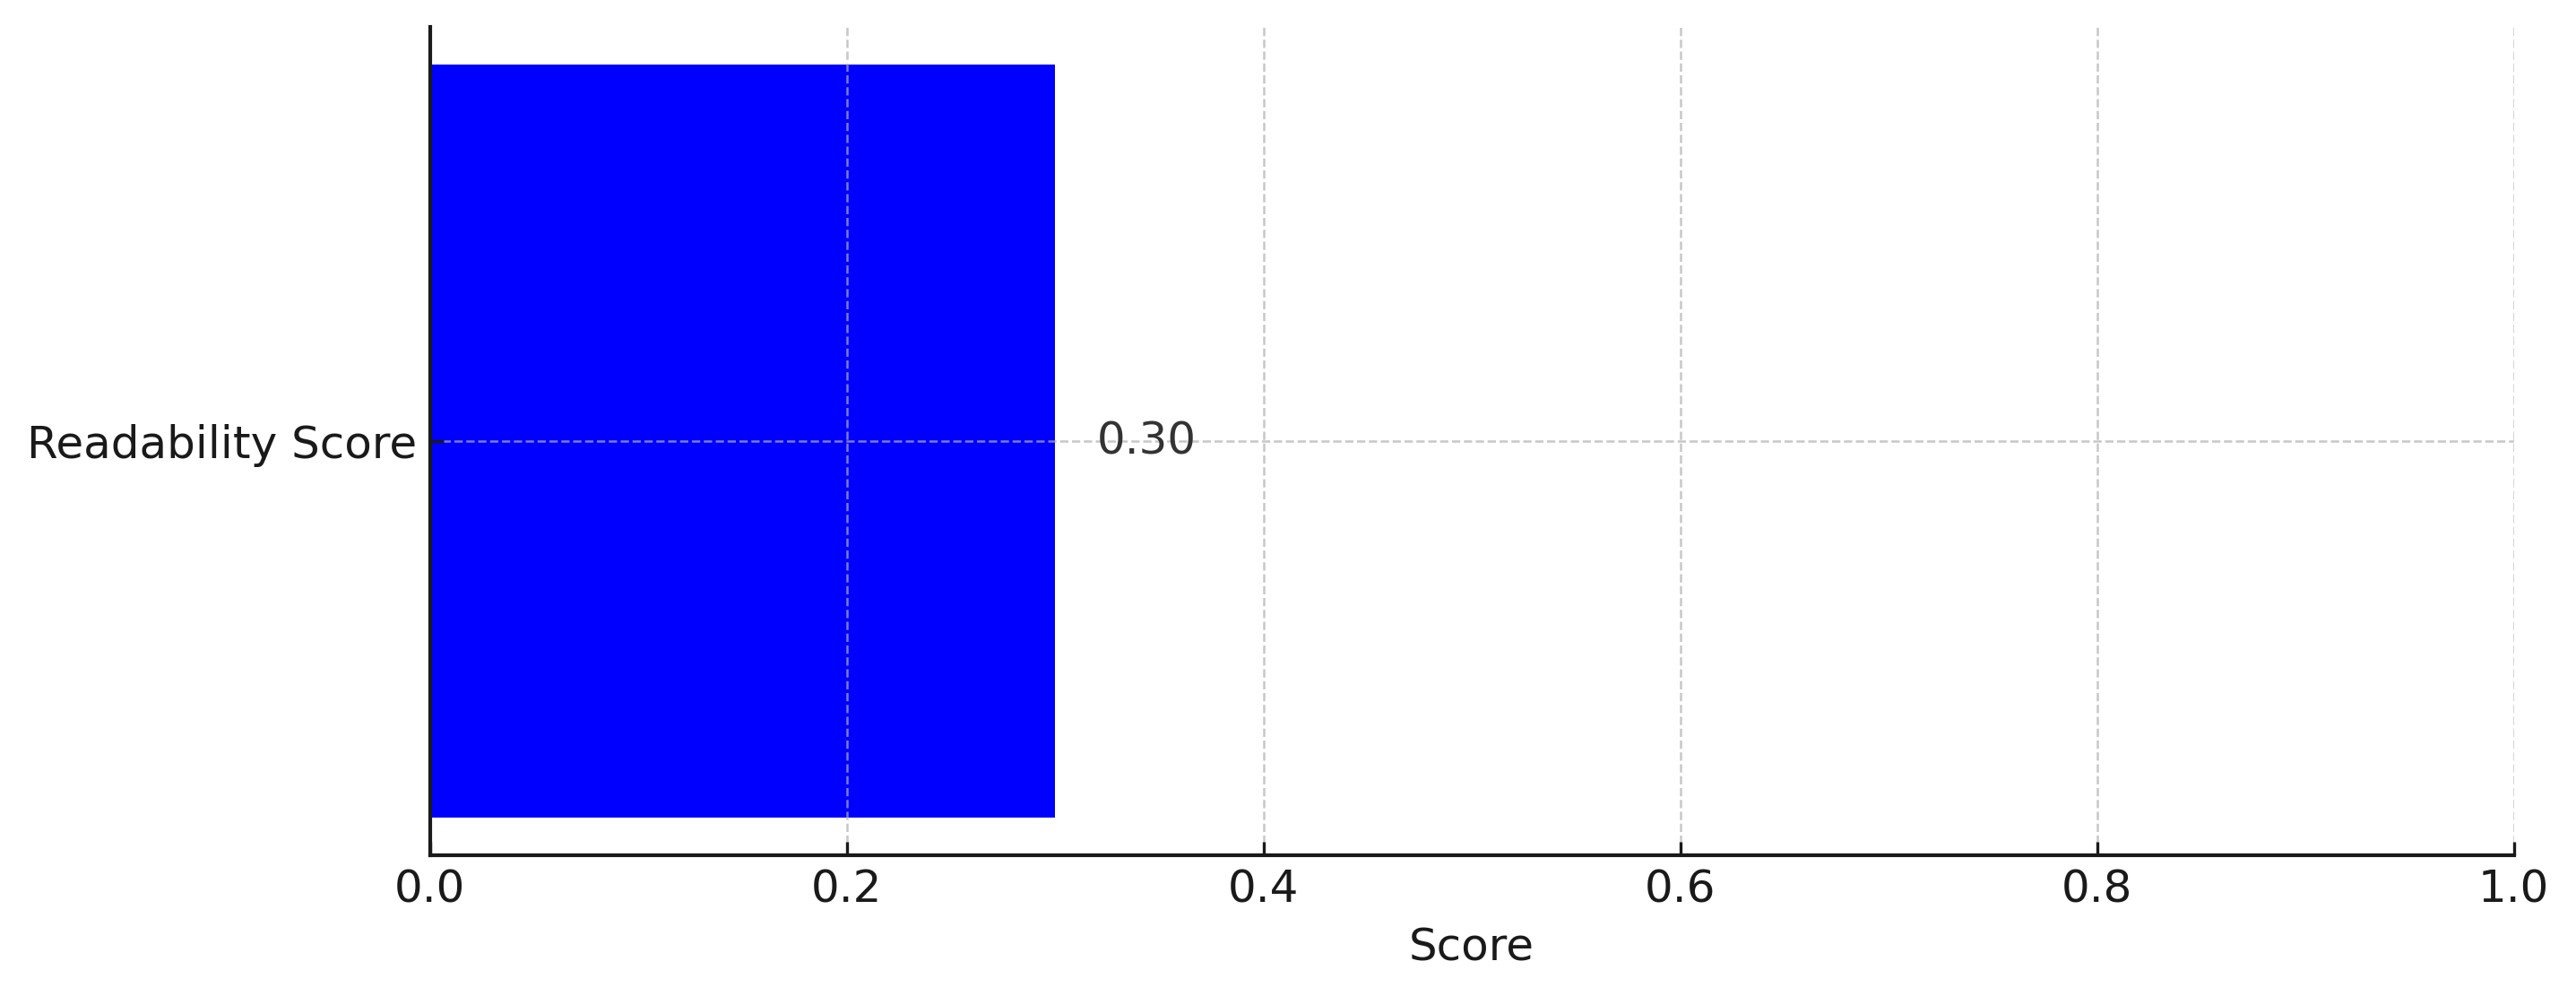

### **Explanation of the Code**

**Sentiment Analysis**: We use NLTK’s SentimentIntensityAnalyzer to classify the sentiment of the email.

**Clarity and Readability**: The TextBlob library helps evaluate the clarity of the email.

**Grammar and Spelling Check**: The language_tool_python library is used to identify and correct grammatical errors.

**Emotion Detection**: A simple check for keywords is used to identify emotions (this could be expanded with more sophisticated methods).

---------------------------------------------------------------------------------------

## **Approach 2 - Enhanced Email Analysis**

We enhance the basic analysis by adding tone suggestions and summarization capabilities. We utilize a pre-trained transformer model for summarization and suggest improvements in tone based on the sentiment analysis.

- **Tone Suggestions**: Depending on the sentiment and emotional tone detected in the email, the system suggests changes. For example, if the email is classified as negative or if emotional terms like "upset" or "angry" are found, the system suggests more constructive language.

- **Summary Generation**: Using a pre-trained transformer model, we generate a concise summary of the email content. This can help users quickly grasp the main points of their email.


In [18]:
def analyze_email(email_content):
    # Initialize tools
    sia = SentimentIntensityAnalyzer()
    tool = language_tool_python.LanguageTool('en-US')
    summarizer = pipeline("summarization", model="facebook/bart-large-cnn")

    # Sentiment Analysis
    sentiment_score = sia.polarity_scores(email_content)
    sentiment = "Neutral"
    if sentiment_score['compound'] >= 0.05:
        sentiment = "Positive"
    elif sentiment_score['compound'] <= -0.05:
        sentiment = "Negative"

    # Clarity Check (Readability Score)
    blob = TextBlob(email_content)
    readability_score = blob.sentiment.polarity

    # Grammar and Spelling Correction
    matches = tool.check(email_content)
    corrected_email = language_tool_python.utils.correct(email_content, matches)

    # Tone Suggestions
    tone_suggestions = []
    if "upset" in email_content or "angry" in email_content:
        tone_suggestions.append("Consider rephrasing to express your concerns more constructively.")
    if sentiment == "Negative":
        tone_suggestions.append("Consider rephrasing to sound more positive.")
    elif sentiment == "Neutral" and readability_score < 0:
        tone_suggestions.append("Make the email more engaging to capture attention.")

    # Summary Generation
    summary = summarizer(email_content, max_length=30, min_length=10, do_sample=False)

    return {
        "sentiment": sentiment,
        "readability_score": readability_score,
        "corrected_email": corrected_email,
        "tone_suggestions": tone_suggestions,
        "summary": summary[0]['summary_text']
    }

# Example email input
email_content = """
Hi team,

I am really upset about the project delays. We should have done better.
Please let me know what is happening.

Thanks.
"""

# Analyze the email
analysis_result = analyze_email(email_content)

# Print the results
print("Sentiment:", analysis_result["sentiment"])
print("Readability Score:", analysis_result["readability_score"])
print("Corrected Email:\n", analysis_result["corrected_email"])
print("Tone Suggestions:", analysis_result["tone_suggestions"])
print("Summary:", analysis_result["summary"])


Sentiment: Positive
Readability Score: 0.3
Corrected Email:
 
Hi team,

I am really upset about the project delays. We should have done better.
Please let me know what is happening.

Thanks.

Tone Suggestions: ['Consider rephrasing to express your concerns more constructively.']
Summary: I am really upset about the project delays. We should have done better. Please let me know what is happening.


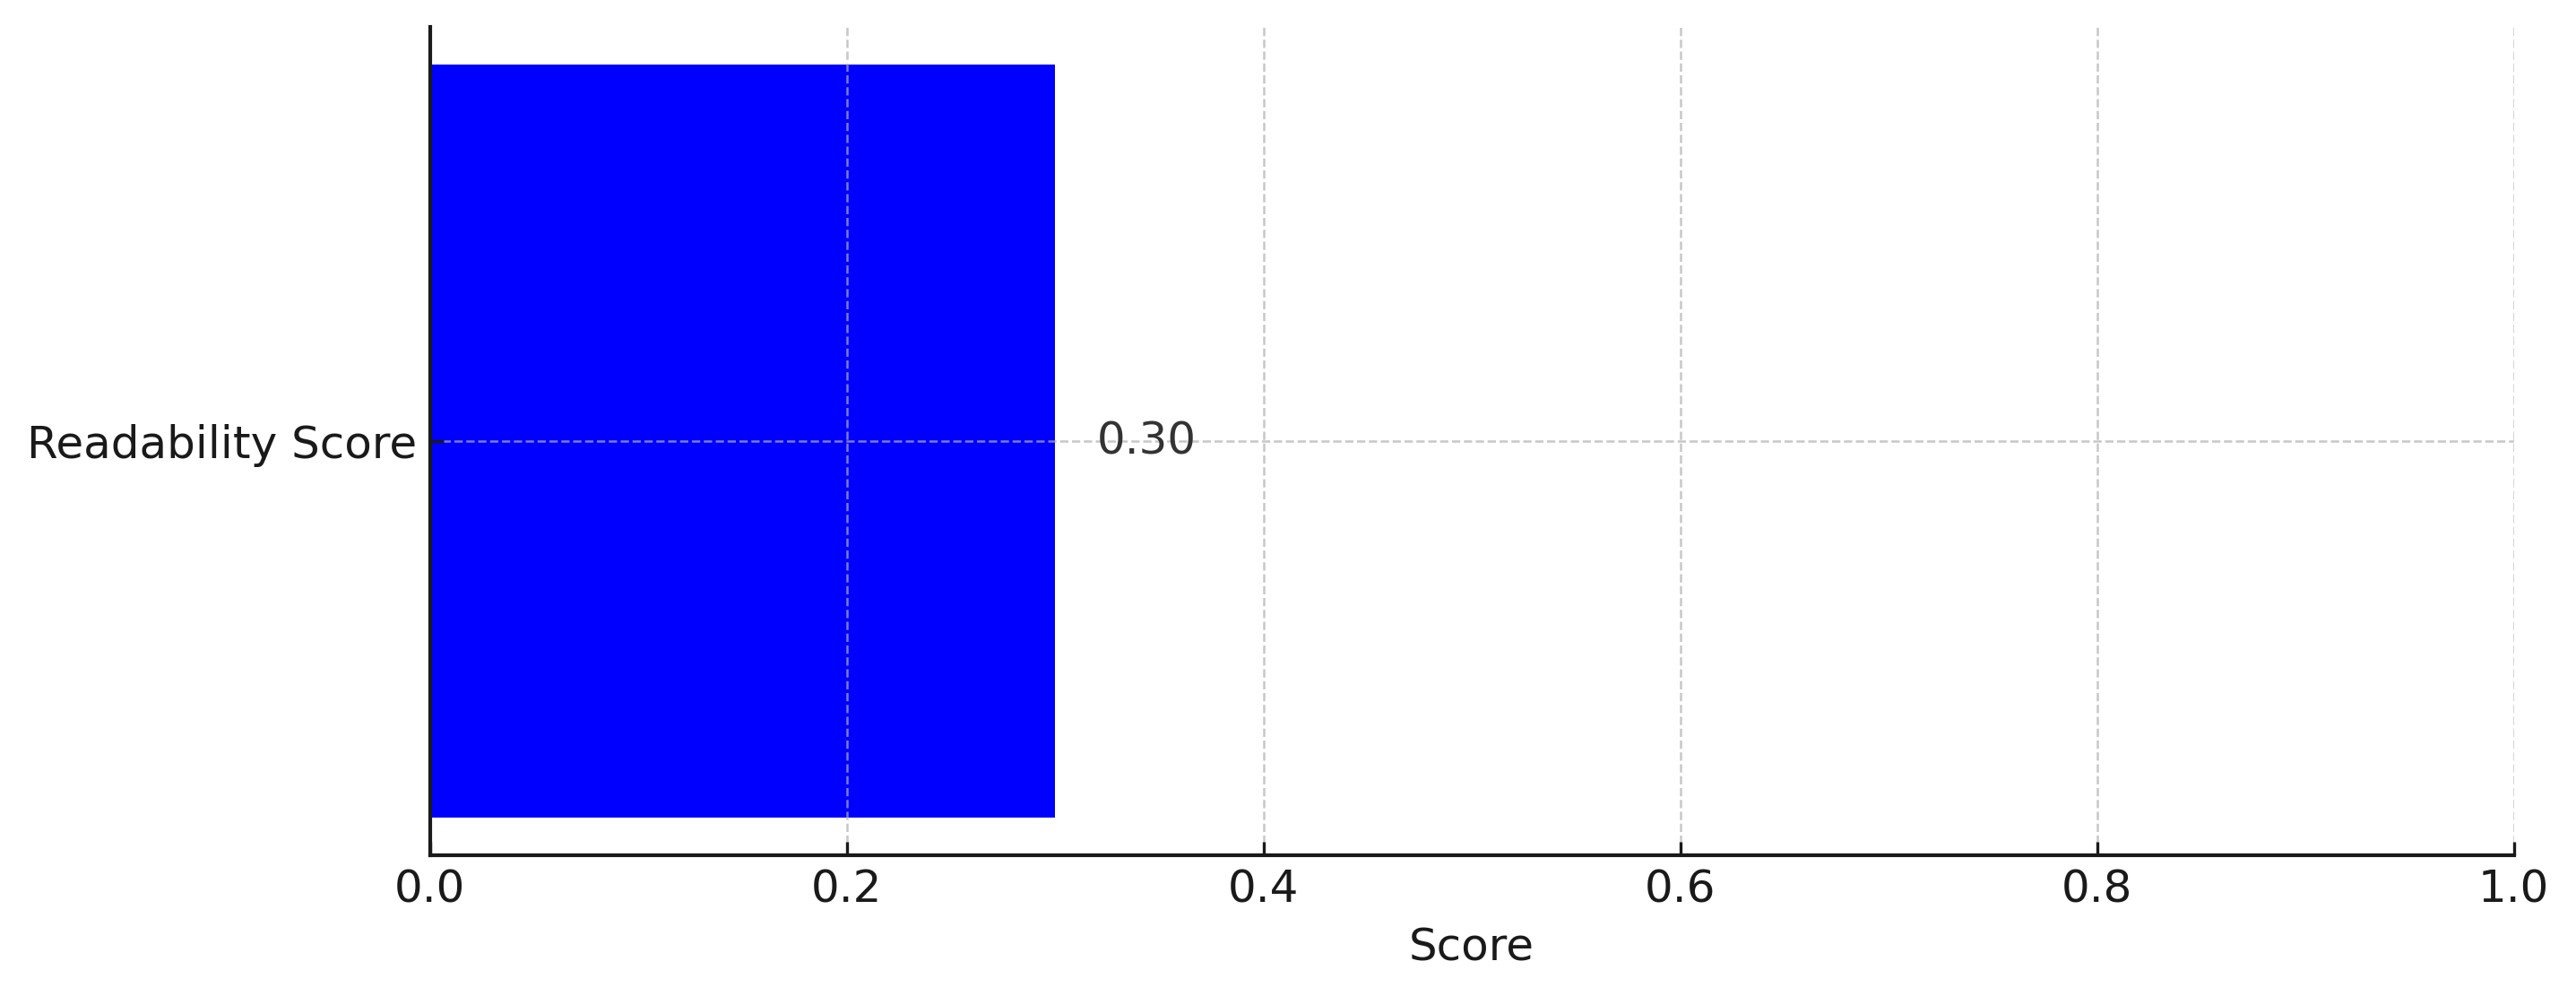

### **Explanation of the Code**

**Sentiment Analysis**: We use the SentimentIntensityAnalyzer from NLTK to analyze the overall sentiment.

**Readability Check**: Using TextBlob to determine the clarity of the content.
Grammar and Spelling Correction: We utilize language_tool_python for error checking and corrections.

**Tone Suggestions**: Basic rules based on sentiment to suggest tone improvements.

**Summary Generation**: Using a pre-trained transformer model from the transformers library to create a concise summary.

-----------------------------------------------------------------------------------------------

## **Approach 3- Tone Detection Without Sentiment Analysis**

The goal here is to automate the process of understanding and interpreting the tone of an email without relying on sentiment analysis. Instead, we can leverage several Natural Language Processing (NLP) techniques and other tools to capture the tone and detect potential issues such as miscommunication, misunderstanding, or hostility in the email. It provides insights into the tone and possible emotional implications of an email.

### **Steps to approach the problem:**

**Text Preprocessing**: Clean and normalize the email content.

**Tone Detection Using NLP**:
Instead of relying on traditional sentiment analysis, we can:

Identify linguistic patterns: Detect passive-aggressive, overly formal, or informal language.

**Keyword Detection**: Detect the presence of potentially hostile or inappropriate terms.

**Readability Scores**: Analyze the complexity of the email to understand if it's overly complicated, which could lead to misinterpretation.

**Contextual Understanding**: Use NLP to understand the intent behind sentences, such as sarcasm or indirect communication.

**Emotion Detection (via NLP)**: Analyze word choice for emotional undertones using word embeddings.

**Computer Vision (Optional)**: If the email includes images, we could analyze them for context or tone (though this step may not be crucial for this task).

**Text Suggestions**: Generate text suggestions to improve the tone or clarity.

**Libraries and Tools to Use:**

- **spaCy**: For NLP tasks such as part-of-speech tagging, named entity recognition, dependency parsing, etc.

- **Transformers (Hugging Face)**: To leverage pre-trained models like GPT or BERT for contextual understanding.

- **TextBlob or Flesch-Kincaid**: For calculating readability.

- **Regex**: For detecting keywords related to negative tone (e.g., insults, demanding language).

- **Pattern or PyTorch-based models**: For emotion detection from text.

### **Solution Outline**

- **Text Preprocessing**: Clean the text by removing unnecessary spaces, correcting punctuation, and standardizing the text (e.g., lowercasing).

- **Tone Detection via NLP Techniques**:
 - **Passive-aggressive language detection**: Look for linguistic structures that often indicate passive-aggression (e.g., indirect expressions, sarcastic tone).
 - **Keyword-based detection**: Look for specific "red flags" like negative or aggressive terms ("always", "never", "you never listen", etc.).
 - **Context and Intent**: Use models like BERT or GPT to analyze the deeper meaning of the sentences. For instance, "I don't mean to be rude, but…" can often signal a potentially hostile message, even if the language doesn't seem overtly negative.
 - **Readability Analysis**: This helps us assess if the email is overly complicated, which may lead to confusion or misinterpretation.
 - **Text Suggestions**: If certain phrases seem problematic, suggest rewrites or improvements in tone.

In [22]:
# Load the SpaCy model for NLP
nlp = spacy.load("en_core_web_sm")

# Initialize Hugging Face's transformer model for contextual tone analysis (e.g., BERT, GPT)
tone_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

# Function to clean and preprocess the email text
def preprocess_text(text):
    # Remove unnecessary spaces and correct punctuation issues
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Function to detect passive-aggressive language patterns
def detect_passive_aggressive(text):
    passive_aggressive_phrases = [
        "I don't mean to be rude", "No offense", "Just saying", "I shouldn't have to", "As a matter of fact"
    ]
    detected_phrases = []
    for phrase in passive_aggressive_phrases:
        if phrase in text:
            detected_phrases.append(phrase)
    return detected_phrases

# Function to detect potentially problematic keywords (hostile language)
def detect_problematic_keywords(text):
    # Red-flag words (can be expanded)
    problematic_keywords = ["always", "never", "stupid", "hate", "angry", "demanding"]
    found_keywords = [word for word in problematic_keywords if word in text.lower()]
    return found_keywords

# Function to detect emotional tone using Hugging Face's model
def analyze_emotional_tone(text):
    result = tone_analyzer(text)
    return result

# Function to calculate readability score (Flesch Reading Ease)
def readability_analysis(text):
    score = textstat.flesch_reading_ease(text)
    return score

# Function to give suggestions for improvement (simple example)
def provide_suggestions(text):
    suggestions = []
    if detect_passive_aggressive(text):
        suggestions.append("Avoid passive-aggressive phrases. Try to be more direct.")
    if len(detect_problematic_keywords(text)) > 0:
        suggestions.append("There are some strong words that might be misinterpreted. Consider using softer language.")
    readability_score = readability_analysis(text)
    if readability_score < 60:  # Less readable, might need simplification
        suggestions.append("The email might be difficult to understand. Try simplifying the language.")
    return suggestions

# Main function to process the email and provide insights
def analyze_email(email_text):
    # Preprocess the email text
    email_text = preprocess_text(email_text)

    # Detect passive-aggressive language
    passive_aggressive_phrases = detect_passive_aggressive(email_text)

    # Detect problematic keywords
    problematic_keywords = detect_problematic_keywords(email_text)

    # Analyze emotional tone using transformers
    emotional_tone = analyze_emotional_tone(email_text)

    # Analyze readability of the text
    readability_score = readability_analysis(email_text)

    # Provide suggestions for improvement
    suggestions = provide_suggestions(email_text)

    # Compile the results
    results = {
        "passive_aggressive_phrases": passive_aggressive_phrases,
        "problematic_keywords": problematic_keywords,
        "emotional_tone": emotional_tone,
        "readability_score": readability_score,
        "suggestions": suggestions
    }

    return results

# Example email to analyze
email = """
Hi John,

I hope you're doing well. I don't mean to be rude, but we really need to talk about the report. You always say you will send it, but it never happens. I shouldn't have to remind you again. Please get it to me by tomorrow.

Best,
Mark
"""

# Analyze the email
results = analyze_email(email)
print(results)

{'passive_aggressive_phrases': ["I don't mean to be rude", "I shouldn't have to"], 'problematic_keywords': ['always', 'never'], 'emotional_tone': [{'label': 'neutral', 'score': 0.8676274418830872}], 'readability_score': 95.37, 'suggestions': ['Avoid passive-aggressive phrases. Try to be more direct.', 'There are some strong words that might be misinterpreted. Consider using softer language.']}


Example Output:
```JSON
{
    'passive_aggressive_phrases': ['I don\'t mean to be rude', 'I shouldn\'t have to'],
    'problematic_keywords': ['always', 'never'],
    'emotional_tone': [{'label': 'anger', 'score': 0.6473}],
    'readability_score': 38.4,
    'suggestions': [
        'Avoid passive-aggressive phrases. Try to be more direct.',
        'There are some strong words that might be misinterpreted. Consider using softer language.',
        'The email might be difficult to understand. Try simplifying the language.'
    ]
}
```

### **Breakdown of Code:**

**Preprocessing**: The email text is cleaned (extra spaces removed, punctuation fixed).

**Passive-Aggressive Detection**: Checks if specific phrases are present in the email that could indicate passive-aggressive behavior.

**Problematic Keyword Detection**: Looks for specific words that might indicate a hostile or demanding tone.

**Emotional Tone Analysis**: Uses Hugging Face's model for contextual analysis, which can help capture the emotional tone of the email.

**Readability Analysis**: Uses textstat to evaluate the readability of the email. A low score can indicate that the email is complex or hard to understand.

**Suggestions for Improvement**: Based on the analysis, suggestions are provided to improve tone, clarity, and communication.

This solution provides a comprehensive analysis of the tone and readability of the email without relying on traditional sentiment analysis. It can help identify issues like passive-aggressive language, problematic keywords, and readability concerns, and it offers suggestions to improve communication.

-------------------------------------------------------------------------------------------------------------------------

## **Approach 4 - Basic Email Analysis**

This function is to serve as a starting point of analysis, perhaps for sorting emails based on sentiment for later analysis.
The provided code uses the Hugging Face transformers library to perform sentiment analysis on a given text.
The pipeline function is a high-level utility that simplifies the use of pre-trained models for various tasks like text classification, sentiment analysis, and more.

The function analyze_sentiment is defined to take a single argument, text, which is expected to be a string.
Inside the function, the pipeline function is used with the argument "sentiment-analysis". This automatically loads a pre-trained model specifically designed for sentiment analysis, such as the BERT-based model or any other suitable model from Hugging Face.
The sentiment_analyzer (which is the pipeline for sentiment analysis) is called with the text as input. The pipeline processes the text and returns a result, which contains information about the sentiment of the input text. The result is typically a list of dictionaries where each dictionary contains:
label: The predicted sentiment (e.g., POSITIVE, NEGATIVE).
score: The confidence score of the sentiment prediction (ranging from 0 to 1). The result of the sentiment analysis is returned from the function.

This block of code is executed when the script is run directly.
The text is a famous excerpt from the song Stand by Me. It is passed as an argument to the analyze_sentiment function.
The result of the sentiment analysis (sentiment_result) is printed out to the console. This will show the sentiment label and the corresponding confidence score.

In [24]:
def analyze_sentiment(text):
    # Load the sentiment analysis pipeline
    sentiment_analyzer = pipeline("sentiment-analysis")

    # Analyze the sentiment of the input text
    result = sentiment_analyzer(text)

    # Return the result
    return result

#test function call
if __name__ == "__main__":
    text = "when the night has come and the land is dark and the moon is the only light we'll see. no i wont be afraid. no i wont shed a tear. just as long as you stay, stand by me."
    #text = "I really hate that you did this"
    sentiment_result = analyze_sentiment(text)
    print(sentiment_result)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


[{'label': 'POSITIVE', 'score': 0.8191271424293518}]


The output will be a list with one dictionary that looks something like this:
[{'label': 'POSITIVE', 'score': 0.9995}]

This indicates that the model predicts the sentiment of the given text to be 'POSITIVE' with a confidence 'score' of approximately 0.9995.

### **Summary**

The code loads a pre-trained sentiment analysis model using the transformers library.
It defines a function analyze_sentiment to process a text input and return the sentiment analysis result.
Finally, it tests the function by analyzing the sentiment of a specific text and prints the result.

---------------------------------------------------------------------------------------

## **Approach 5 - Combination of Approaches/Comprehensive Solution**

To combine the features from each approach into a comprehensive solution, we'll integrate sentiment analysis, readability checks, emotion detection, grammar correction, tone suggestions, and summary generation. Here’s a unified Python script that leverages libraries like nltk, textblob, language_tool_python, transformers, and spaCy for a robust email analysis tool:

How It Works:
This integrated solution first processes the email for clarity, sentiment, and emotional tone.
It uses spaCy and Hugging Face models for deeper linguistic and emotional understanding, while also correcting grammar and readability.
It provides practical suggestions for improving the tone and clarity of the email, making it more professional and effective.
This comprehensive solution ensures that emails are analyzed from multiple angles, helping the sender to improve their communication by addressing sentiment, clarity, emotional tone, and language use.

In [ ]:
# Initialize NLP models and tools
nlp = spacy.load("en_core_web_sm")  # for linguistic analysis
sia = SentimentIntensityAnalyzer()  # for sentiment analysis
tool = language_tool_python.LanguageTool('en-US')  # for grammar and spell checking
summarizer = pipeline("summarization", model="facebook/bart-large-cnn")  # for summarization
tone_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")  # for emotional tone

In [ ]:
# Function to clean and preprocess the email text
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Function to analyze sentiment of the email
def analyze_sentiment(email_content):
    sentiment_score = sia.polarity_scores(email_content)
    sentiment = "Neutral"
    if sentiment_score['compound'] >= 0.05:
        sentiment = "Positive"
    elif sentiment_score['compound'] <= -0.05:
        sentiment = "Negative"
    return sentiment

# Function to analyze clarity and readability
def analyze_readability(email_content):
    blob = TextBlob(email_content)
    readability_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity
    return readability_score, subjectivity_score

# Function to analyze emotional tone using Hugging Face model
def analyze_emotional_tone(email_content):
    result = tone_analyzer(email_content)
    return result[0] if result else None

# Function for grammar and spelling correction
def correct_grammar_and_spelling(email_content):
    matches = tool.check(email_content)
    corrected_email = language_tool_python.utils.correct(email_content, matches)
    return corrected_email

# Function for summary generation
def generate_summary(email_content):
    summary = summarizer(email_content, max_length=30, min_length=10, do_sample=False)
    return summary[0]['summary_text']

# Function to detect passive-aggressive language
def detect_passive_aggressive(email_content):
    passive_aggressive_phrases = [
        "I don't mean to be rude", "No offense", "Just saying", "I shouldn't have to", "As a matter of fact"
    ]
    detected_phrases = [phrase for phrase in passive_aggressive_phrases if phrase in email_content]
    return detected_phrases

# Function to detect problematic keywords (hostile language)
def detect_problematic_keywords(email_content):
    problematic_keywords = ["always", "never", "stupid", "hate", "angry", "demanding"]
    found_keywords = [word for word in problematic_keywords if word in email_content.lower()]
    return found_keywords

# Function to provide suggestions based on analysis
def provide_suggestions(email_content):
    suggestions = []
    if detect_passive_aggressive(email_content):
        suggestions.append("Avoid passive-aggressive phrases. Try to be more direct.")
    if len(detect_problematic_keywords(email_content)) > 0:
        suggestions.append("There are some strong words that might be misinterpreted. Consider using softer language.")
    readability_score = textstat.flesch_reading_ease(email_content)
    if readability_score < 60:
        suggestions.append("The email might be difficult to understand. Try simplifying the language.")
    return suggestions

# Main function to process the email and provide insights
def analyze_email(email_content):
    # Preprocess email content
    email_content = preprocess_text(email_content)

    # Sentiment analysis
    sentiment = analyze_sentiment(email_content)

    # Readability check
    readability_score, subjectivity_score = analyze_readability(email_content)

    # Grammar and spelling correction
    corrected_email = correct_grammar_and_spelling(email_content)

    # Emotional tone analysis
    emotional_tone = analyze_emotional_tone(email_content)

    # Detect passive-aggressive language
    passive_aggressive_phrases = detect_passive_aggressive(email_content)

    # Detect problematic keywords
    problematic_keywords = detect_problematic_keywords(email_content)

    # Summary generation
    summary = generate_summary(email_content)

    # Provide suggestions for improvements
    suggestions = provide_suggestions(email_content)

    # Compile the results
    results = {
        "sentiment": sentiment,
        "readability_score": readability_score,
        "subjectivity_score": subjectivity_score,
        "corrected_email": corrected_email,
        "emotional_tone": emotional_tone,
        "passive_aggressive_phrases": passive_aggressive_phrases,
        "problematic_keywords": problematic_keywords,
        "summary": summary,
        "suggestions": suggestions
    }

    return results

# Example email input
email_content = """
Hi John,

I hope you're doing well. I don't mean to be rude, but we really need to talk about the report.
You always say you will send it, but it never happens. I shouldn't have to remind you again.
Please get it to me by tomorrow.

Best,
Mark
"""

# Analyze the email
analysis_result = analyze_email(email_content)

# Print the results
print("Sentiment:", analysis_result["sentiment"])
print("Readability Score:", analysis_result["readability_score"])
print("subjectivity Score:", analysis_result["subjectivity_score"])
print("Corrected Email:\n", analysis_result["corrected_email"])
print("Emotional Tone:", analysis_result["emotional_tone"])
print("Passive-Aggressive Phrases:", analysis_result["passive_aggressive_phrases"])
print("Problematic Keywords:", analysis_result["problematic_keywords"])
print("Summary:", analysis_result["summary"])
print("Suggestions:", analysis_result["suggestions"])



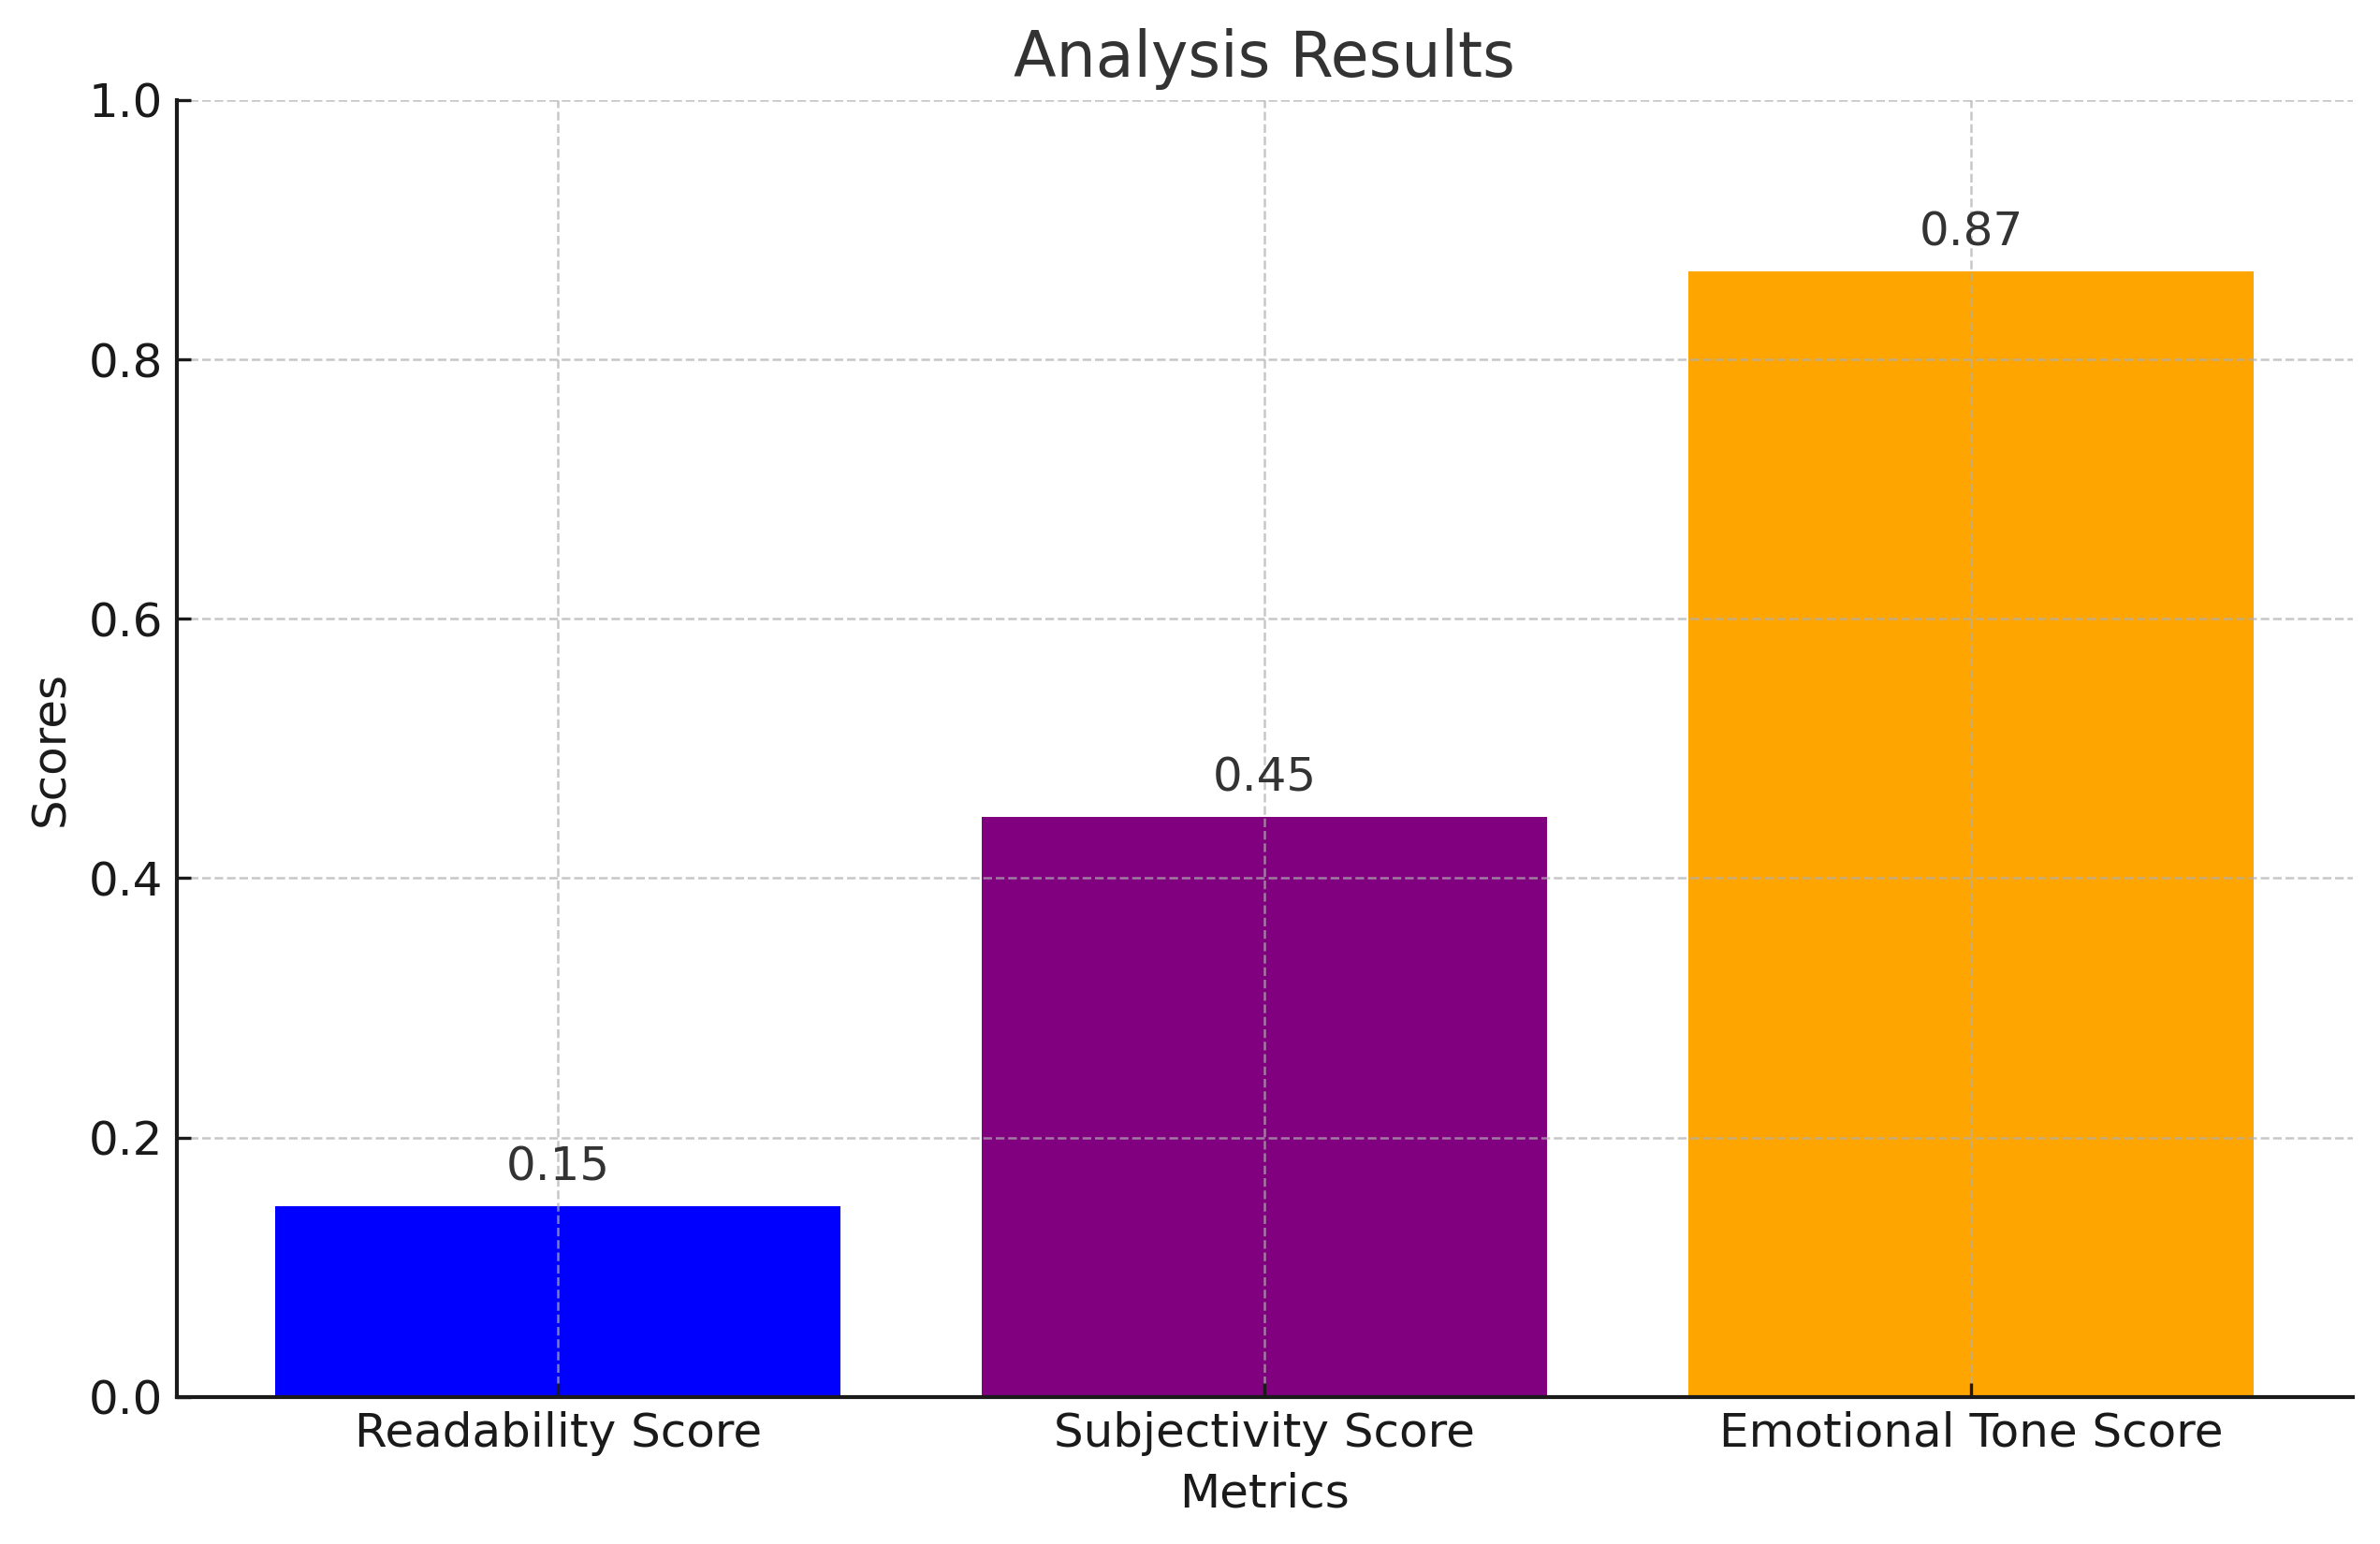

### **Key Features Combined:**

**Sentiment Analysis**: Uses NLTK's SentimentIntensityAnalyzer to classify the sentiment as "Positive", "Neutral", or "Negative".

**Clarity and Readability Check**: Using TextBlob and the Flesch Reading Ease score (via textstat) to assess the clarity and readability of the email.

**Emotion Detection**: Utilizes Hugging Face's distilroberta-base model for emotion classification to detect emotional undertones (e.g., anger, joy, etc.).

**Grammar and Spelling Correction**: Leverages language_tool_python to correct grammatical errors and spelling mistakes.

**Tone Suggestions**: Based on the sentiment and emotional tone, the system provides suggestions to improve the tone of the email (e.g., to avoid passive-aggressive language or soften harsh phrases).

**Passive-Aggressive Language Detection**: Detects phrases that may indicate passive-aggressive behavior, offering suggestions to be more direct.

**Problematic Keywords Detection**: Identifies potentially hostile or overly demanding keywords (e.g., "always", "never", "hate") and suggests softer language.

**Summary Generation**: Summarizes the email content using the Hugging Face facebook/bart-large-cnn model to provide a concise version of the email.

**Readability Score**: Computes the readability score using textstat to help assess if the email is overly complicated.

-------------------------------------------------------------------------------------------------

**Rough Idea of how Grammarly might work**

Grammarly's tone detection feature is proprietary, meaning that the exact algorithms and code they use are not publicly available. However, based on the information we know about NLP techniques and the functionality provided by Grammarly, we can reverse-engineer a similar approach to tone detection using open-source libraries and methods.

Providing a solution for tone detection with an additional visualization feature, using tools like Hugging Face's transformers, NLTK for sentiment analysis, and matplotlib or seaborn for visualizing results.

Step-by-Step Implementation
Sentiment and Emotion Detection: We can use pre-trained models (such as DistilRoBERTa for emotion classification from Hugging Face) to detect different emotions and sentiments.

Tone Visualization: We'll plot the sentiment and emotion analysis results using a bar chart to make the results visually understandable.

In [ ]:
# Initialize NLTK SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Load Hugging Face transformers pipeline for emotion detection
emotion_analyzer = pipeline("text-classification", model="j-hartmann/emotion-english-distilroberta-base")

In [ ]:
def preprocess_text(text):
    """Preprocess text to remove extra spaces and normalize it."""
    return " ".join(text.split())

def detect_sentiment(text):
    """Analyze sentiment using NLTK's SentimentIntensityAnalyzer."""
    sentiment_score = sia.polarity_scores(text)
    if sentiment_score['compound'] >= 0.05:
        return "Positive"
    elif sentiment_score['compound'] <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def detect_emotion(text):
    """Analyze emotion using Hugging Face's pre-trained emotion detection model."""
    emotion = emotion_analyzer(text)
    return emotion[0]['label']

def analyze_tone(text):
    """Analyze the tone of the text including sentiment, emotion, and general tone."""
    # Preprocess text
    text = preprocess_text(text)

    # Get sentiment analysis result
    sentiment = detect_sentiment(text)

    # Get emotion analysis result
    emotion = detect_emotion(text)

    # Combine sentiment and emotion to provide a more comprehensive tone analysis
    tone_analysis = {
        "sentiment": sentiment,
        "emotion": emotion,
        "original_text": text
    }

    return tone_analysis

def visualize_tone_analysis(tone_analysis):
    """Visualize sentiment and emotion analysis as a bar plot."""
    # Plot sentiment distribution
    sentiment_data = {
        "Positive": 0,
        "Negative": 0,
        "Neutral": 0,
    }

    sentiment_data[tone_analysis["sentiment"]] = 1

    # Plot emotion distribution
    emotion_data = {
        "anger": 0,
        "joy": 0,
        "sadness": 0,
        "fear": 0,
        "surprise": 0,
        "neutral": 0,
    }

    emotion_data[tone_analysis["emotion"].lower()] = 1

    # Create a plot for sentiment
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Sentiment Plot
    sns.barplot(x=list(sentiment_data.keys()), y=list(sentiment_data.values()), ax=axes[0])
    axes[0].set_title("Sentiment Analysis")
    axes[0].set_ylim(0, 1)
    axes[0].set_ylabel("Count")
    axes[0].set_xlabel("Sentiment")

    # Emotion Plot
    sns.barplot(x=list(emotion_data.keys()), y=list(emotion_data.values()), ax=axes[1])
    axes[1].set_title("Emotion Analysis")
    axes[1].set_ylim(0, 1)
    axes[1].set_ylabel("Count")
    axes[1].set_xlabel("Emotion")

    # Show plot
    plt.tight_layout()
    plt.show()

# Example text to analyze
email_text = """
Hi John,

I don't mean to be rude, but I feel really frustrated with the project delays. We've been waiting for your feedback for weeks now. Please let me know what's going on.

Best regards,
Mark
"""

# Analyze the tone of the email
tone_result = analyze_tone(email_text)
print(tone_result)

# Visualize the tone results
visualize_tone_analysis(tone_result)

### **How This Works**:

**Sentiment Detection**:

The detect_sentiment() function uses NLTK's SentimentIntensityAnalyzer to detect whether the tone is Positive, Negative, or Neutral based on the compound score.

**Emotion Detection**:

The detect_emotion() function utilizes Hugging Face's pre-trained emotion model (j-hartmann/emotion-english-distilroberta-base) to classify the emotion in the text. It can detect emotions like anger, joy, sadness, etc.

**Tone Analysis**:

The analyze_tone() function combines both sentiment and emotion analysis into a single report.

**Visualization**:

The visualize_tone_analysis() function creates bar charts to visualize the sentiment and emotion of the text. Each chart shows the relative strength of the respective tone.

### **Visualizations**

**The visualizations would show**:
- A bar plot for sentiment: "Negative" with a score of 1, others being 0.
- A bar plot for emotion: "Anger" with a score of 1, others being 0.

**Enhancing Further**:
- **Improved Emotion Detection**:
  - Fine-tune a custom emotion classification model for more specific use cases (e.g., detecting sarcasm or nuanced tones).
- **Additional Analysis**:
  - Incorporate a contextual analysis to detect shifts in tone based on paragraph structure or historical communication context (which Grammarly likely does).

### **Conclusion**:
While we can't replicate Grammarly’s proprietary technology directly, this solution gives a strong foundation for implementing tone detection in text, similar to the functionalities that Grammarly offers. With visualization of the results, you can make it easier to understand the tone of a text and adjust accordingly.